In [435]:
!pip install langcodes


[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [436]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from langcodes import standardize_tag

from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection as mdl
from sklearn import metrics as met
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.metrics import accuracy_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import preprocessing as pre
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline, FeatureUnion

In [437]:
user_info_df = pd.read_csv('user_attributes.csv')
user_activity_df = pd.read_csv('user_activities.csv')

EDA

user_info_df

In [438]:
print(user_info_df.shape)
user_info_df.head(2)

(681663, 6)


,country,preferred_language,is_company,ID,gender,mobile_device
0,nl,nl,False,1,Male,iOS
1,nl,nl,False,2,Female,iOS


In [439]:
user_info_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 681663 entries, 0 to 681662
Data columns (total 6 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   country             681663 non-null  object
 1   preferred_language  681663 non-null  object
 2   is_company          681663 non-null  bool  
 3   ID                  681663 non-null  int64 
 4   gender              681663 non-null  object
 5   mobile_device       511292 non-null  object
dtypes: bool(1), int64(1), object(4)
memory usage: 26.7+ MB


In [440]:
# Missing Value Check
for i in user_info_df.columns[user_info_df.isnull().any()].tolist():
    print('%12s  %4.0f' % (i, user_info_df[i].isnull().values.sum()))

mobile_device  170371


In [441]:
user_info_df.mobile_device = ["UNK" if x is np.nan else x for x in user_info_df.mobile_device]

In [442]:
# Unique ID Count
unique_id_count = user_info_df['ID'].nunique()
print(f"Unique ID Count: {unique_id_count}")

Unique ID Count: 681663


In [443]:
# IDs with more than 1 record
id_counts = user_info_df['ID'].value_counts()
duplicate_ids = id_counts[id_counts > 1]

print(duplicate_ids)

Series([], Name: count, dtype: int64)


In [444]:
# Preferred language standardization

user_info_df['preferred_language'] = user_info_df['preferred_language'].apply(lambda x: standardize_tag(x))

language_counts = user_info_df['preferred_language'].value_counts()

low_frequency_languages = language_counts[language_counts < 1000].index
user_info_df.loc[user_info_df['preferred_language'].isin(low_frequency_languages), 'preferred_language'] = 'other'

user_info_df['preferred_language'].value_counts()

preferred_language
nl       534404
en        66560
de        31746
fr        18330
ro        13390
pl         6695
it         3985
hu         2907
es         2254
other      1392
Name: count, dtype: int64

In [445]:
# Country standardization

user_info_df['country'] = user_info_df['country'].apply(lambda x: standardize_tag(x))

country_counts = user_info_df['country'].value_counts()

low_frequency_country = country_counts[country_counts < 5000].index
user_info_df.loc[user_info_df['country'].isin(low_frequency_country), 'country'] = 'other'

user_info_df['country'].value_counts()

country
nl       484612
be        92254
other     44161
de        25511
ro        19141
fr         8262
pl         7722
Name: count, dtype: int64

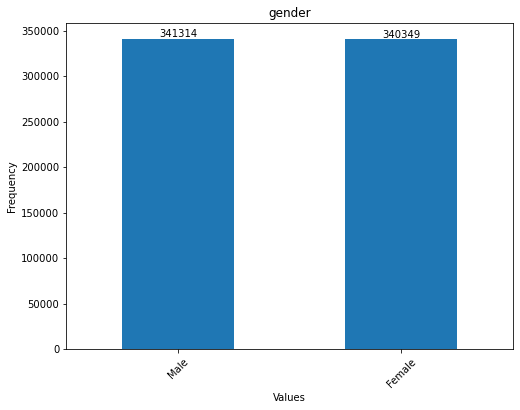

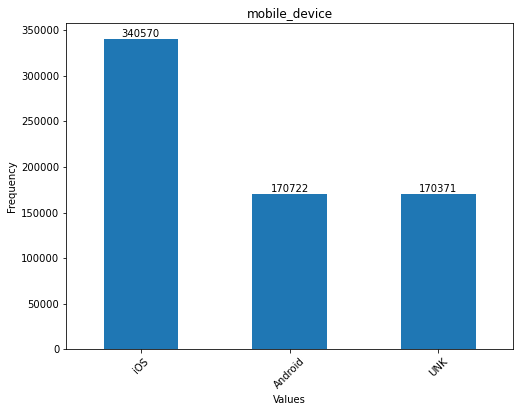

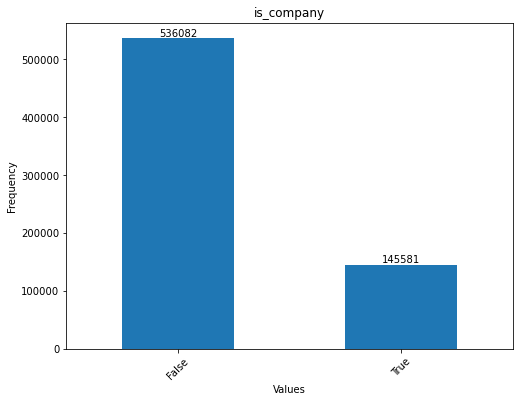

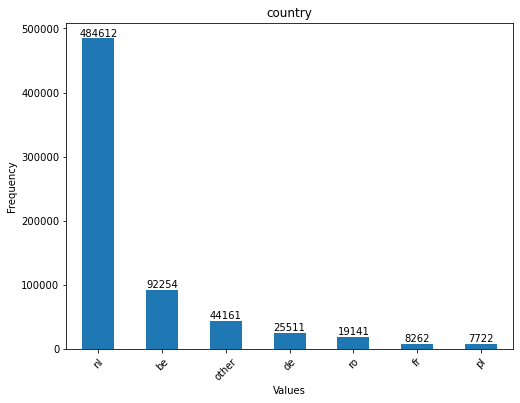

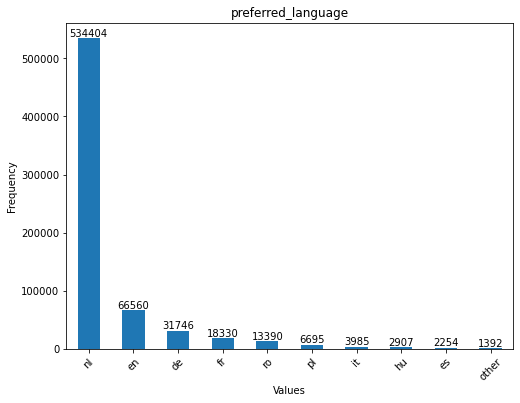

In [446]:
categorical_columns = ['gender', 'mobile_device', 'is_company','country','preferred_language']

for column in categorical_columns:
    plt.figure(figsize=(8, 6))
    value_counts = user_info_df[column].value_counts()
    value_counts.plot(kind='bar')
    plt.title(f'{column}')
    plt.xlabel('Values')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)

    for i, count in enumerate(value_counts):
        plt.text(i, count + 0.1, str(count), ha='center', va='bottom')

    plt.show()

user_activity_df

In [447]:
print(user_activity_df.shape)
user_activity_df.head(2)

(4010637, 12)


,ID,start_date_of_week,week,year,unique_lots_viewed,amount_views,bidded_on_amount_lots,bids_places,total_bidded,money_spend,amount_lots_won,platform
0,17179873627,2023-06-17,25,2023,34,39,0,0,0.00,0.00,0,TWK
1,240518168627,2023-06-17,25,2023,24,26,0,0,0.00,0.00,0,TWK


In [448]:
user_activity_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4010637 entries, 0 to 4010636
Data columns (total 12 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   ID                     int64  
 1   start_date_of_week     object 
 2   week                   int64  
 3   year                   int64  
 4   unique_lots_viewed     int64  
 5   amount_views           int64  
 6   bidded_on_amount_lots  int64  
 7   bids_places            int64  
 8   total_bidded           float64
 9   money_spend            float64
 10  amount_lots_won        int64  
 11  platform               object 
dtypes: float64(2), int64(8), object(2)
memory usage: 367.2+ MB


In [449]:
# Time Frame
print(min(user_activity_df['start_date_of_week']))
print(max(user_activity_df['start_date_of_week']))

2022-12-24
2024-02-24


In [450]:
# #Missing Values
for i in user_activity_df.columns[user_activity_df.isna().any()].tolist():
    print('%12s  %4.0f' % (i, user_activity_df[i].isna().values.sum()))

In [451]:
# Unique ID Count
unique_id_count = user_activity_df['ID'].nunique()
print(f"Unique ID Count: {unique_id_count}")

Unique ID Count: 681663


In [452]:
# IDs with more than 1 record
duplicate_records = user_activity_df.groupby(['ID', 'week', 'year']).size().reset_index(name='record_count')

# Duplicate records
print(duplicate_records[duplicate_records['record_count'] > 1])

Empty DataFrame
Columns: [ID, week, year, record_count]
Index: []


In [453]:
# Common ID Check
not_common_ids = user_info_df[~user_info_df['ID'].isin(user_activity_df['ID'])]
not_common_id_list = not_common_ids['ID'].tolist()
print(len(not_common_ids['ID']))

not_common_ids_2 = user_activity_df[~user_activity_df['ID'].isin(user_info_df['ID'])]
print(len(not_common_ids_2['ID']))

0
0


In [454]:
# Negatif Column Check
numeric_cols = user_activity_df.select_dtypes(include=['number']).columns
neg_cols = [col for col in numeric_cols if (user_activity_df[col] < 0).any()]

print(neg_cols) #OK

[]


In [455]:
# Platform
user_activity_df['platform'].value_counts()

platform
TWK       3009504
BVA        967882
VAVATO      33251
Name: count, dtype: int64

In [456]:
user_activity_df[(user_activity_df['platform']=='BVA')&(user_activity_df['bids_places']!=0)] #There's no bidding activity from the BVA platform

,ID,start_date_of_week,week,year,unique_lots_viewed,amount_views,bidded_on_amount_lots,bids_places,total_bidded,money_spend,amount_lots_won,platform


In [457]:
df_platform = user_activity_df[['ID','platform']].drop_duplicates()

In [458]:
# Logical Inconsistency
# If ı apply the rules, the data decreases significantly. I kept the records as my domain knowledge is not certain.
"""print(user_activity_df.shape)
user_activity_df = user_activity_df.drop(user_activity_df[user_activity_df['bidded_on_amount_lots'] > user_activity_df['unique_lots_viewed']].index)
user_activity_df = user_activity_df.drop(user_activity_df[user_activity_df['amount_lots_won'] > user_activity_df['bidded_on_amount_lots']].index)
user_activity_df = user_activity_df.drop(user_activity_df[user_activity_df['money_spend'] > user_activity_df['total_bidded']].index)
print(user_activity_df.shape)"""

"print(user_activity_df.shape)\nuser_activity_df = user_activity_df.drop(user_activity_df[user_activity_df['bidded_on_amount_lots'] > user_activity_df['unique_lots_viewed']].index)\nuser_activity_df = user_activity_df.drop(user_activity_df[user_activity_df['amount_lots_won'] > user_activity_df['bidded_on_amount_lots']].index)\nuser_activity_df = user_activity_df.drop(user_activity_df[user_activity_df['money_spend'] > user_activity_df['total_bidded']].index)\nprint(user_activity_df.shape)"

In [459]:
# The number of user who have bid at least once
unique_viewed_ids = user_activity_df[user_activity_df['amount_views'] > 0]['ID'].nunique()
print("Unique Viewed IDs:", unique_viewed_ids)

unique_bidded_ids = user_activity_df[user_activity_df['bids_places'] > 0]['ID'].nunique()
print("Unique Bidded IDs:", unique_bidded_ids)

Unique Viewed IDs: 681663
Unique Bidded IDs: 8448


In [460]:
# Viewers and action-oriented users
bid_ids = user_activity_df[user_activity_df['bids_places'] != 0]['ID']
df_onlybiddedusers = user_activity_df.loc[user_activity_df['ID'].isin(bid_ids)]

In [461]:
# Adding start date of week again
df_onlybiddedusers.drop('start_date_of_week', axis=1, inplace=True)
df_onlybiddedusers['start_date_of_week'] = pd.to_datetime(df_onlybiddedusers['year'].astype(str) + '-W' + df_onlybiddedusers['week'].astype(str) + '-1', format='%Y-W%W-%w')

C:\Users\ISILAY~1\AppData\Local\Temp/ipykernel_16468/317773143.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_onlybiddedusers.drop('start_date_of_week', axis=1, inplace=True)
C:\Users\ISILAY~1\AppData\Local\Temp/ipykernel_16468/317773143.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_onlybiddedusers['start_date_of_week'] = pd.to_datetime(df_onlybiddedusers['year'].astype(str) + '-W' + df_onlybiddedusers['week'].astype(str) + '-1', format='%Y-W%W-%w')


Feature Engineering

In [462]:
user_info_df = user_info_df[['ID','gender','is_company','country','preferred_language','mobile_device']]

In [463]:
# Users who have never bid are removed from the dataset. The reason why they only made views can be investigated through another analysis.
bidded_ids = user_info_df[~user_info_df['ID'].isin(df_onlybiddedusers['ID'])]
bidded_id_list = bidded_ids['ID'].tolist()

In [464]:
df_model = user_info_df.copy()

print(df_model.shape)
df_model = df_model[~df_model['ID'].isin(bidded_id_list)]
print(df_model.shape)

(681663, 6)
(8448, 6)


In [465]:
# Adding the platform info
df_model = df_model.merge(df_platform, on='ID', how='left')

In [466]:
# Recency
max_date = df_onlybiddedusers['start_date_of_week'].max()

recency_df = df_onlybiddedusers.groupby('ID')['start_date_of_week'].max().reset_index()
recency_df.columns = ['ID', 'MaxWeekStartDate']

recency_df['Recency'] = (max_date - recency_df['MaxWeekStartDate']).dt.days

df_model = df_model.merge(recency_df[['ID','Recency']], on='ID', how='left')

# Monetary
monetary_df = user_activity_df.groupby('ID')['money_spend'].sum().reset_index()
monetary_df.columns = ['ID', 'Monetary']

df_model = df_model.merge(monetary_df[['ID','Monetary']], on='ID', how='left')

In [467]:
# Tenure
tenure_df = df_onlybiddedusers.groupby('ID')['start_date_of_week'].min().reset_index()

tenure_df.columns = ['ID', 'MinWeekStartDate']

tenure_df['Tenure'] = (max_date - tenure_df['MinWeekStartDate']).dt.days

df_model = df_model.merge(tenure_df[['ID','Tenure','MinWeekStartDate']], on='ID', how='left')

In [468]:
#Frequency
df_model['MaxWeekStartDate'] = max_date
df_model['WeeksBetween'] = ((df_model['MaxWeekStartDate'] - df_model['MinWeekStartDate']).dt.days // 7) + 1

view_df = df_onlybiddedusers.groupby('ID').size().reset_index(name='ViewWeeks')
df_model = df_model.merge(view_df[['ID','ViewWeeks']], on='ID', how='left')

bidded_df = df_onlybiddedusers[df_onlybiddedusers['bids_places']!=0].groupby('ID').size().reset_index(name='BiddedWeeks')
df_model = df_model.merge(bidded_df[['ID','BiddedWeeks']], on='ID', how='left')

In [469]:
df_model['View_Frequency'] = df_model['ViewWeeks']/df_model['WeeksBetween']
df_model['Bid_Frequency'] = df_model['BiddedWeeks']/df_model['ViewWeeks']

In [470]:
df_model[['Recency','Monetary','Tenure','View_Frequency','Bid_Frequency']].describe()

,Recency,Monetary,Tenure,View_Frequency,Bid_Frequency
count,8448.00,8448.00,8448.00,8448.00,8448.00
mean,119.45,81403.03,338.36,0.40,0.15
std,33.55,515787.06,102.69,0.21,0.22
min,0.00,1.00,0.00,0.02,0.02
25%,105.00,825.00,259.00,0.21,0.03
50%,133.00,4985.00,385.00,0.40,0.06
75%,140.00,28000.00,427.00,0.58,0.14
max,357.00,19847630.00,427.00,1.00,1.00


In [471]:
drop_list = ['MinWeekStartDate','MaxWeekStartDate','WeeksBetween','ViewWeeks','BiddedWeeks']

df_model.drop(columns=drop_list, inplace=True)

In [472]:
# Unique Lots View
unique_lots_df = df_onlybiddedusers.groupby('ID').apply(lambda x: (x['unique_lots_viewed'].sum() / x['amount_views'].sum())).reset_index(name='UniqueLotsView_percentage')

df_model = df_model.merge(unique_lots_df[['ID','UniqueLotsView_percentage']], on='ID', how='left')

In [473]:
# Bid Rate
bid_percentage_df = df_onlybiddedusers.groupby('ID').apply(lambda x: (x['bidded_on_amount_lots'].sum() / x['unique_lots_viewed'].sum())).reset_index(name='Bid_percentage')

df_model = df_model.merge(bid_percentage_df[['ID','Bid_percentage']], on='ID', how='left')

In [474]:
# Bid Won Rate
bid_won_percentage_df = df_onlybiddedusers.groupby('ID').apply(lambda x: (x['amount_lots_won'].sum() / x['bidded_on_amount_lots'].sum())).reset_index(name='BidWon_percentage')

df_model = df_model.merge(bid_won_percentage_df[['ID','BidWon_percentage']], on='ID', how='left')

In [475]:
# Avg Money per Bid
avg_money_per_bid = df_onlybiddedusers.groupby('ID').apply(lambda x: (x['money_spend'].sum() / x['bids_places'].sum()) * 100).reset_index(name='AvgMoney_ByBid')

df_model = df_model.merge(avg_money_per_bid[['ID','AvgMoney_ByBid']], on='ID', how='left')
df_model['AvgMoney_ByBid'] = df_model['AvgMoney_ByBid'].fillna(0)

In [476]:
df_model.head(2)

,ID,gender,is_company,country,preferred_language,mobile_device,platform,Recency,Monetary,Tenure,View_Frequency,Bid_Frequency,UniqueLotsView_percentage,Bid_percentage,BidWon_percentage,AvgMoney_ByBid
0,5,Male,False,nl,nl,Android,TWK,140,1908.00,413,0.65,0.03,0.59,0.00,0.00,63600.00
1,11,Male,True,nl,nl,Android,TWK,105,285.00,427,0.68,0.02,0.70,0.00,0.00,7125.00


In [477]:
result_last_1M = df_onlybiddedusers[df_onlybiddedusers['start_date_of_week'] >= max_date - pd.DateOffset(months=1)].groupby('ID').agg({
    'unique_lots_viewed': 'sum',
    'amount_views': 'sum',
    'bidded_on_amount_lots': 'sum',
    'bids_places': 'sum',
    'total_bidded': 'sum',
    'money_spend': 'sum',
    'amount_lots_won' : 'sum'
}).reset_index()

result_last_1M.columns = ['ID', 'unique_lots_viewed_1M', 'amount_views_1M', 'bidded_on_amount_lots_1M', 'bids_places_1M','total_bidded_1M', 
                          'money_spend_1M','amount_lots_won_1M']


In [478]:
result_last_3M = df_onlybiddedusers[df_onlybiddedusers['start_date_of_week'] >= max_date - pd.DateOffset(months=3)].groupby('ID').agg({
    'unique_lots_viewed': 'sum',
    'amount_views': 'sum',
    'bidded_on_amount_lots': 'sum',
    'bids_places': 'sum',
    'total_bidded': 'sum',
    'money_spend': 'sum',
    'amount_lots_won' : 'sum'
}).reset_index()

result_last_3M.columns = ['ID', 'unique_lots_viewed_3M', 'amount_views_3M', 'bidded_on_amount_lots_3M', 'bids_places_3M','total_bidded_3M', 
                          'money_spend_3M','amount_lots_won_3M']


In [479]:
result_last_6M = df_onlybiddedusers[df_onlybiddedusers['start_date_of_week'] >= max_date - pd.DateOffset(months=6)].groupby('ID').agg({
    'unique_lots_viewed': 'sum',
    'amount_views': 'sum',
    'bidded_on_amount_lots': 'sum',
    'bids_places': 'sum',
    'total_bidded': 'sum',
    'money_spend': 'sum',
    'amount_lots_won' : 'sum'
}).reset_index()

result_last_6M.columns = ['ID', 'unique_lots_viewed_6M', 'amount_views_6M', 'bidded_on_amount_lots_6M', 'bids_places_6M','total_bidded_6M', 
                          'money_spend_6M','amount_lots_won_6M']


In [480]:
# Total Values
result_all = df_onlybiddedusers.groupby('ID').agg({
    'unique_lots_viewed': 'sum',
    'amount_views': 'sum',
    'bidded_on_amount_lots': 'sum',
    'bids_places': 'sum',
    'total_bidded': 'sum',
    'money_spend': 'sum',
    'amount_lots_won' : 'sum'
}).reset_index()

result_all.columns = ['ID', 'unique_lots_viewed_All', 'amount_views_All', 'bidded_on_amount_lots_All', 'bids_places_All','total_bidded_All', 
                          'money_spend_All','amount_lots_won_All']

In [481]:
df_model = pd.merge(df_model, result_last_1M, on='ID', how='left')
df_model = pd.merge(df_model, result_last_3M, on='ID', how='left')
df_model = pd.merge(df_model, result_last_6M, on='ID', how='left')
df_model = pd.merge(df_model, result_all, on='ID', how='left')

# Fill Na
df_model = df_model.fillna(0)

In [482]:
# Avg Values
result_avg = df_onlybiddedusers.groupby('ID').agg({
    'unique_lots_viewed': 'mean',
    'amount_views': 'mean',
    'bidded_on_amount_lots': 'mean',
    'bids_places': 'mean',
    'total_bidded': 'mean',
    'money_spend': 'mean',
    'amount_lots_won' : 'mean'
}).reset_index()

result_avg.columns = ['ID', 'unique_lots_viewed_Avg', 'amount_views_Avg', 'bidded_on_amount_lots_Avg', 'bids_places_Avg','total_bidded_Avg', 
                          'money_spend_Avg','amount_lots_won_Avg']

In [483]:
df_model = pd.merge(df_model, result_avg, on='ID', how='left')

In [484]:
df_model.shape

(8448, 51)

Adding Target

In [485]:
# Recency Distribution
bins = pd.cut(df_model['Recency'], bins=range(0, df_model['Recency'].max()+1, 30), right=False)
bin_counts = df_model.groupby(bins).size()

print(bin_counts)

Recency
[0, 30)        218
[30, 60)        59
[60, 90)      1015
[90, 120)     1779
[120, 150)    5187
[150, 180)     132
[180, 210)      44
[210, 240)       0
[240, 270)       0
[270, 300)       0
[300, 330)       2
dtype: int64


C:\Users\ISILAY~1\AppData\Local\Temp/ipykernel_16468/420473622.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_counts = df_model.groupby(bins).size()


In [486]:
recency_distribution = df_model['Recency'].describe(percentiles=[0.25, 0.5, 0.75, 0.95])
pd.set_option('display.float_format', lambda x: '%.2f' % x)
print(recency_distribution)

count   8448.00
mean     119.45
std       33.55
min        0.00
25%      105.00
50%      133.00
75%      140.00
95%      147.00
max      357.00
Name: Recency, dtype: float64


In [487]:
df_model['Churn'] = 0
df_model.loc[df_model['Recency'] > 140, 'Churn'] = 1

In [488]:
df_model['Churn'].value_counts()

Churn
0    7905
1     543
Name: count, dtype: int64

Features with Churn 

Text(0.5, 1.0, 'Churn vs Recency')

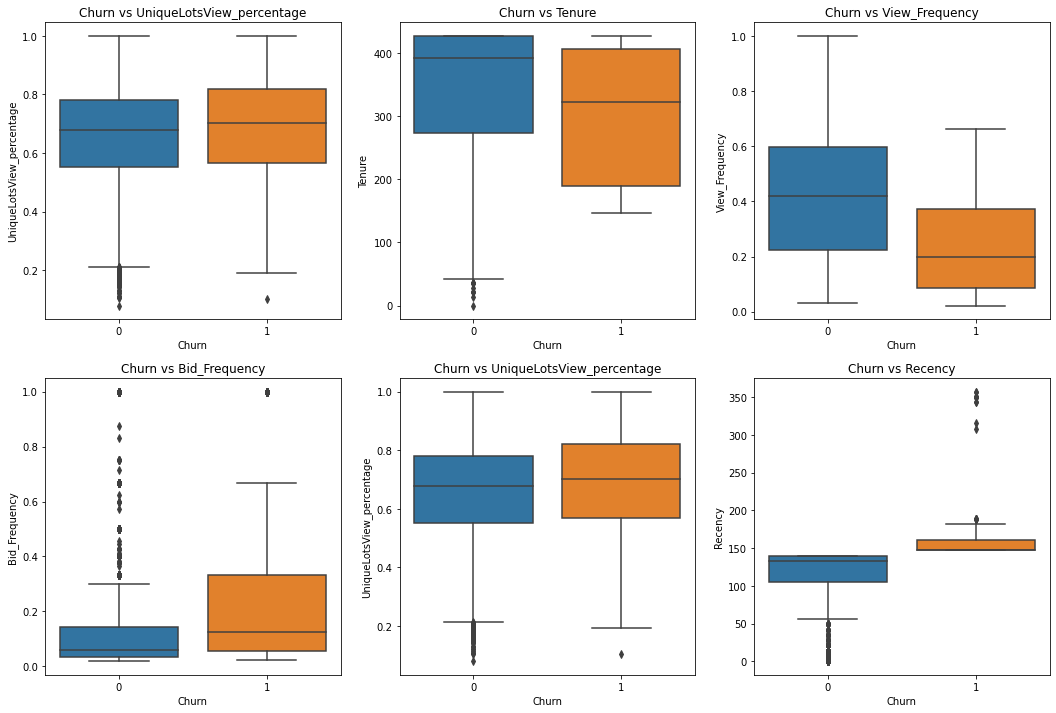

In [489]:
# Numeric Features
fig, axes = plt.subplots(2, 3, figsize=(18, 12))  # 2 satır, 3 sütunlu alt grafikler oluşturur

sns.boxplot(x='Churn', y='UniqueLotsView_percentage', data=df_model, ax=axes[0, 0])
axes[0, 0].set_title("Churn vs UniqueLotsView_percentage")

sns.boxplot(x='Churn', y='Tenure', data=df_model, ax=axes[0, 1])
axes[0, 1].set_title("Churn vs Tenure")

sns.boxplot(x='Churn', y='View_Frequency', data=df_model, ax=axes[0, 2])
axes[0, 2].set_title("Churn vs View_Frequency")

sns.boxplot(x='Churn', y='Bid_Frequency', data=df_model, ax=axes[1, 0])
axes[1, 0].set_title("Churn vs Bid_Frequency")

sns.boxplot(x='Churn', y='UniqueLotsView_percentage', data=df_model, ax=axes[1, 1])
axes[1, 1].set_title("Churn vs UniqueLotsView_percentage")

sns.boxplot(x='Churn', y='Recency', data=df_model, ax=axes[1, 2])
axes[1, 2].set_title("Churn vs Recency")

Text(0.5, 1.0, 'Churn vs Language')

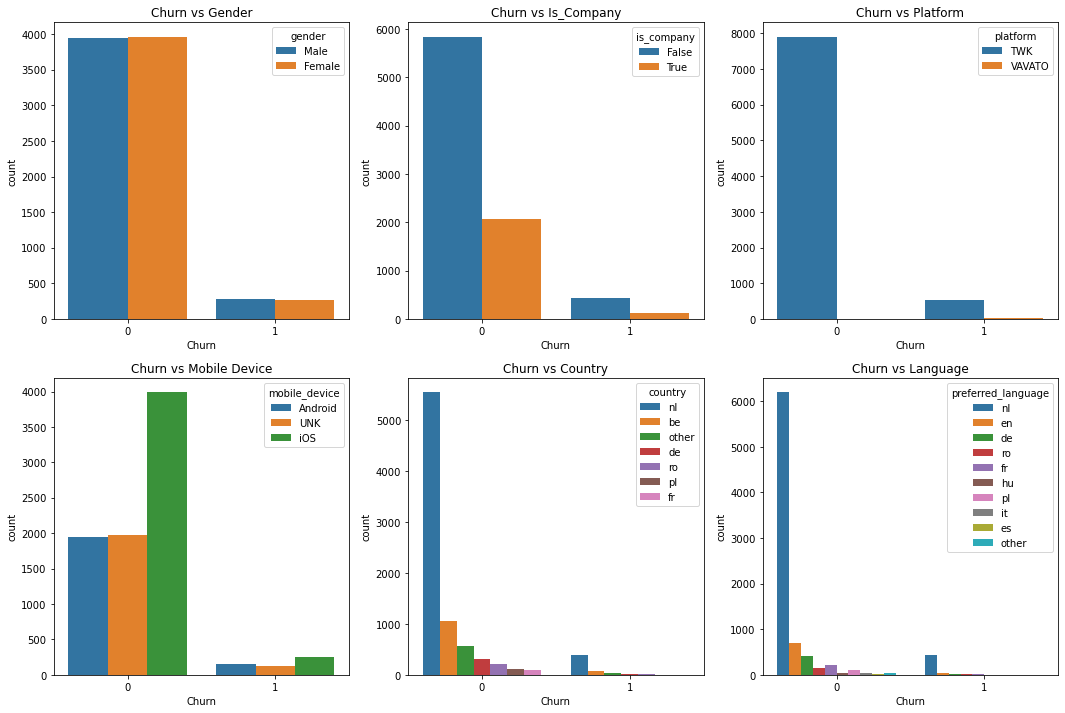

In [490]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))  # 3 satır, 3 sütunlu alt grafikler oluşturur

# Numeric Features
sns.countplot(x='Churn', hue='gender', data=df_model, ax=axes[0, 0])
axes[0, 0].set_title("Churn vs Gender")

sns.countplot(x='Churn', hue='is_company', data=df_model, ax=axes[0, 1])
axes[0, 1].set_title("Churn vs Is_Company")

sns.countplot(x='Churn', hue='platform', data=df_model, ax=axes[0, 2])
axes[0, 2].set_title("Churn vs Platform")

sns.countplot(x='Churn', hue='mobile_device', data=df_model, ax=axes[1, 0])
axes[1, 0].set_title("Churn vs Mobile Device")

sns.countplot(x='Churn', hue='country', data=df_model, ax=axes[1, 1])
axes[1, 1].set_title("Churn vs Country")

sns.countplot(x='Churn', hue='preferred_language', data=df_model, ax=axes[1, 2])
axes[1, 2].set_title("Churn vs Language")

Correlation Check 

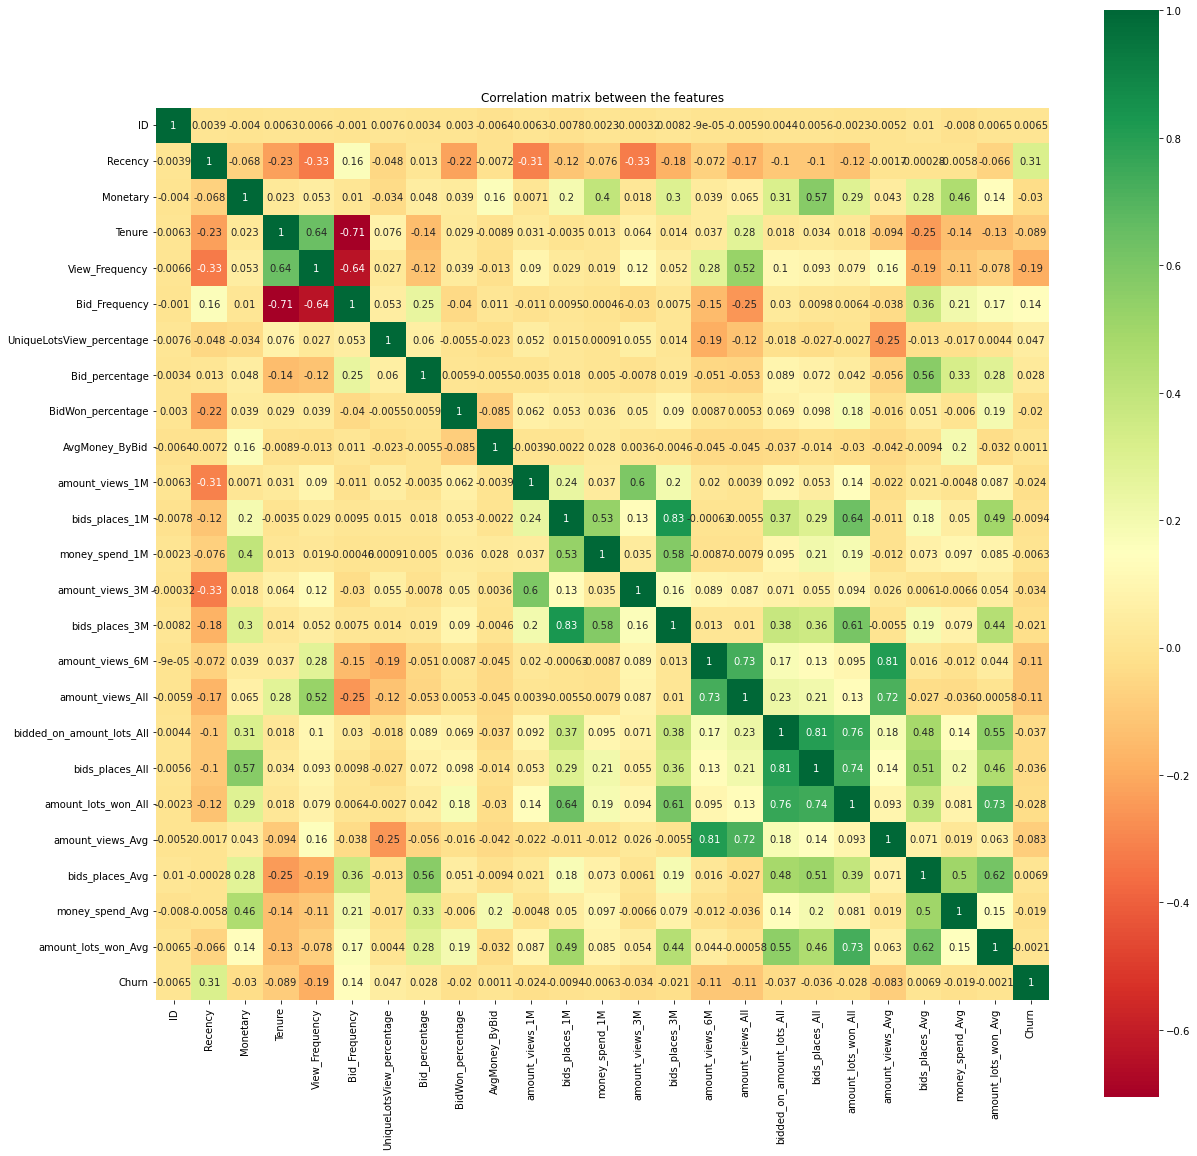

In [541]:
import seaborn as sns

numeric_df_model = df_model.select_dtypes(include=['float64', 'int64'])

# Korelasyon matrisi oluşturma
correlation_matrix = numeric_df_model.corr()

plt.figure(figsize=(20,20))
ax = sns.heatmap(correlation_matrix, vmax=1, square=True,annot=True,cmap='RdYlGn')
plt.title('Correlation matrix between the features')
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.show()

In [542]:
correlation_matrix = numeric_df_model.corr()

# Korelasyon matrisini üst üçgen olarak al
upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
sorted_correlation = upper_triangle.unstack().sort_values(ascending=False)

sorted_correlation.head(15)

bids_places_3M       bids_places_1M              0.83
amount_views_Avg     amount_views_6M             0.81
bids_places_All      bidded_on_amount_lots_All   0.81
amount_lots_won_All  bidded_on_amount_lots_All   0.76
                     bids_places_All             0.74
amount_views_All     amount_views_6M             0.73
amount_lots_won_Avg  amount_lots_won_All         0.73
amount_views_Avg     amount_views_All            0.72
View_Frequency       Tenure                      0.64
amount_lots_won_All  bids_places_1M              0.64
amount_lots_won_Avg  bids_places_Avg             0.62
amount_lots_won_All  bids_places_3M              0.61
amount_views_3M      amount_views_1M             0.60
bids_places_3M       money_spend_1M              0.58
bids_places_All      Monetary                    0.57
dtype: float64

In [ ]:
drop_list = ['money_spend_All','total_bidded_All','money_spend_6M','bids_places_6M','bidded_on_amount_lots_6M',
             'total_bidded_1M','amount_lots_won_6M','total_bidded_3M','unique_lots_viewed_3M','unique_lots_viewed_1M',
             'bidded_on_amount_lots_1M','bidded_on_amount_lots_3M','total_bidded_6M','amount_lots_won_1M',
             'unique_lots_viewed_All','unique_lots_viewed_6M','unique_lots_viewed_Avg','money_spend_3M','total_bidded_Avg',
             'bidded_on_amount_lots_Avg','amount_lots_won_3M']

df_model.drop(columns=drop_list, inplace=True)

Feature Importance with RandomForest

In [543]:
df_model2 = df_model.copy()

df_model2.drop(['ID','Recency'], axis=1, inplace=True)
df_model2['is_company'] = df_model2['is_company'].astype(int)

In [544]:
X = df_model2.drop("Churn",axis=1)
y = df_model2["Churn"]

In [545]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=7)

In [546]:
cat_col_names = list(X.select_dtypes(include="object").columns)
num_col_names = X.select_dtypes(exclude="object").columns

In [547]:
def convertToArray(X):
  return X.toarray()

def selectCatFeatures(X):
  return X[cat_col_names]

def selectNumFeatures(X):
  return X[num_col_names]

In [ ]:
# GridSearchCV for parameter tuning
pipe_num = Pipeline([
              ("select_cat", pre.FunctionTransformer(selectNumFeatures)),  
              ("scaler", pre.StandardScaler())
])

pipe_cat = Pipeline([
              ("select_cat", pre.FunctionTransformer(selectCatFeatures)),
              ("one-hot", pre.OneHotEncoder(handle_unknown="ignore")),
              ("toarray", pre.FunctionTransformer(convertToArray))

])

union = FeatureUnion([
              ("cat", pipe_cat),
              ("num", pipe_num)
])

pipe_final = Pipeline([
              ("union", union),
              ("scale", pre.StandardScaler()),
              ("rnd",   RandomForestClassifier(random_state=42))
])

params_rf = {
    "rnd__n_estimators": [100, 200, 300],  
    "rnd__max_depth": [None, 5, 10],  
    "rnd__min_samples_split": [2, 4, 6],  
    "rnd__min_samples_leaf": [1, 2, 3, 4],
}

grid_rf = GridSearchCV(pipe_final, params_rf, cv=3)
grid_rf.fit(X_train, y_train)
best_model = grid_rf.best_estimator_
print(grid_rf.best_params_)

y_pred = cross_val_predict(best_model, X_train, y_train, cv=3)
print(classification_report(y_train, y_pred))

In [549]:
pipe_num = Pipeline([
              ("select_cat", pre.FunctionTransformer(selectNumFeatures)),  
              ("scaler", pre.StandardScaler())
])

pipe_cat = Pipeline([
              ("select_cat", pre.FunctionTransformer(selectCatFeatures)),
              ("one-hot", pre.OneHotEncoder(handle_unknown="ignore")),
              ("toarray", pre.FunctionTransformer(convertToArray))

])

union = FeatureUnion([
              ("cat", pipe_cat),
              ("num", pipe_num)
])

pipe_final = Pipeline([
              ("union", union),
              ("scale", pre.StandardScaler()),
              ("rnd",   RandomForestClassifier(n_estimators= 200, min_samples_split= 6,random_state=42))
])

y_pred = cross_val_predict(pipe_final, X_train, y_train, cv=3)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      5534
           1       0.97      0.16      0.27       379

    accuracy                           0.95      5913
   macro avg       0.96      0.58      0.62      5913
weighted avg       0.95      0.95      0.93      5913



In [550]:
# Feature importances
pipe_final.fit(X_train, y_train)

random_forest = pipe_final.named_steps['rnd']

feature_importances = random_forest.feature_importances_

feature_importances_dict = dict(zip(X_train.columns, feature_importances))

sorted_features = sorted(feature_importances_dict.items(), key=lambda x: x[1], reverse=True)

print("Sorted Feature Importances:")
for feature, importance in sorted_features:
    print(f"{feature}: {importance}")

Sorted Feature Importances:
amount_lots_won_Avg: 0.13615570533418528
money_spend_Avg: 0.06628118511698429
bids_places_Avg: 0.059267280550370297
bids_places_All: 0.008117410117522315
amount_lots_won_All: 0.007682023657795937
amount_views_6M: 0.00666083501763107
gender: 0.00629255988875544
amount_views_Avg: 0.006186896679829568
amount_views_All: 0.006025339491911404
bidded_on_amount_lots_All: 0.00591860383074325
is_company: 0.0059082926096337635
country: 0.0055576413877345765
platform: 0.004924358635777177
BidWon_percentage: 0.004756753534909568
bids_places_1M: 0.004194976525159696
bids_places_3M: 0.003787656926745966
Bid_percentage: 0.003217258535275903
preferred_language: 0.0031056171918744714
UniqueLotsView_percentage: 0.0030289282233008814
View_Frequency: 0.0029787981536638767
Bid_Frequency: 0.0027065228762557514
Monetary: 0.0022627823605243518
AvgMoney_ByBid: 0.0019627159997830748
amount_views_3M: 0.0008706896196403672
mobile_device: 0.0007114832612106788
Tenure: 0.00063748666004799

Model and Feature Selection

In [277]:
df_model2 = df_model.copy()

df_model2.drop(['ID','Recency'], axis=1, inplace=True)
df_model2['is_company'] = df_model2['is_company'].astype(int)

In [279]:
categorical_columns = df_model2.select_dtypes(include='object').columns.tolist()

def one_hot_encoder(dataframe, categorical_cols, drop_first=True):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

df_model2 = one_hot_encoder(df_model2, categorical_columns)

In [280]:
X = df_model2.drop("Churn",axis=1)
y = df_model2["Churn"]

In [281]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=7)

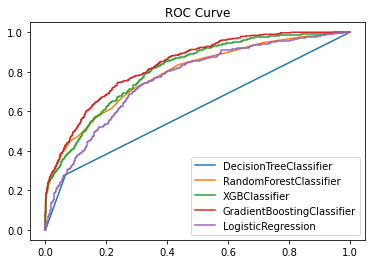

In [238]:
# Model Performance Evaluation
for est in [DecisionTreeClassifier(), RandomForestClassifier(), xgb.XGBClassifier(), GradientBoostingClassifier(), LogisticRegression()]:
  pipe = Pipeline([
                  ("scaler", StandardScaler()),
                  ("clf", est)
                  ])

  if hasattr(est, "decision_function"):
    m = "decision_function"
  else:
    m = "predict_proba"

  scores = mdl.cross_val_predict(pipe, X_train, y_train, cv=3, method=m)

  if not hasattr(est, "decision_function"):
    scores = scores[:, 1]

  fpr, tpr, thresholds = met.roc_curve(y_train, scores)
  plt.plot(fpr, tpr, label = est.__class__.__name__)
  
plt.title("ROC Curve")
plt.legend()
plt.show()

RandomForest

In [282]:
pipe_rf = Pipeline([
    ("scaler", StandardScaler()),
    ("rnd", RandomForestClassifier(n_estimators= 200, min_samples_split= 6,random_state=42))
])

# Çapraz doğrulama ile tahminler yapma
y_pred = cross_val_predict(pipe_rf, X_train, y_train, cv=3)

# Sınıflandırma raporunu yazdırma
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      5534
           1       0.79      0.15      0.25       379

    accuracy                           0.94      5913
   macro avg       0.87      0.57      0.61      5913
weighted avg       0.94      0.94      0.92      5913



In [269]:
# Try class weight for unevenly distributed data
pipe_rf = Pipeline([
    ("scaler", StandardScaler()),
    ("rnd", RandomForestClassifier(n_estimators= 200, min_samples_split= 6, class_weight={0:1, 1:2}, random_state=42))
])

# Çapraz doğrulama ile tahminler yapma
y_pred = cross_val_predict(pipe_rf, X_train, y_train, cv=3)

# Sınıflandırma raporunu yazdırma
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      5534
           1       0.72      0.13      0.23       379

    accuracy                           0.94      5913
   macro avg       0.83      0.57      0.60      5913
weighted avg       0.93      0.94      0.92      5913



XGB

In [ ]:
#XGBClassifier

pipe_xgb = Pipeline([
                 ("scaler", StandardScaler()),
                 ("xgb", xgb.XGBClassifier())
                 ])

params_xgb = {
    "xgb__n_estimators": [100, 150, 200],  
    "xgb__max_depth": [3, 5, 7],  
    "xgb__learning_rate": [0.01, 0.1, 0.2]  
}

grid_xgb = GridSearchCV(pipe_xgb, params_xgb, cv=3)
grid_xgb.fit(X_train, y_train)
best_model = grid_xgb.best_estimator_
print(grid_xgb.best_estimator_)

y_pred = cross_val_predict(best_model, X_train, y_train, cv=3)
print(classification_report(y_train, y_pred))

In [283]:
pipe_xgb = Pipeline([
                 ("scaler", StandardScaler()),
                 ("xgb", xgb.XGBClassifier(learning_rate=0.1, n_estimators=100, max_depth=5, random_state=42))
                 ])

y_pred = mdl.cross_val_predict(pipe_xgb, X_train, y_train, cv=3)
print(met.classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      5534
           1       0.84      0.15      0.25       379

    accuracy                           0.94      5913
   macro avg       0.89      0.57      0.61      5913
weighted avg       0.94      0.94      0.92      5913



In [284]:
#Test Data
pipe_xgb.fit(X_train, y_train)

y_pred_test = pipe_xgb.predict(X_test)

#Results
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_test))

print(classification_report(y_test, y_pred_test))

Confusion Matrix:
[[2367    4]
 [ 144   20]]
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      2371
           1       0.83      0.12      0.21       164

    accuracy                           0.94      2535
   macro avg       0.89      0.56      0.59      2535
weighted avg       0.94      0.94      0.92      2535



GradientBoosting

In [ ]:
#GradientBoosting

pipe_gb = Pipeline([
                 ("scaler", StandardScaler()),
                 ("gb", GradientBoostingClassifier(random_state=42))
                 ])

params_gb = {
    "gb__min_samples_leaf": [4, 5], 
    "gb__max_depth": range(3, 7, 1),  
    "gb__learning_rate": [0.01, 0.1, 0.2],
    "gb__min_samples_leaf":np.linspace(0.1, 0.5, 12)
}

grid_gb = GridSearchCV(pipe_gb, params_gb, cv=3)
grid_gb.fit(X_train, y_train)
best_model = grid_gb.best_estimator_
print(grid_gb.best_estimator_)

y_pred = cross_val_predict(best_model, X_train, y_train, cv=3)
print(classification_report(y_train, y_pred))

In [286]:
pipe_gb = Pipeline([
    ("scaler", StandardScaler()),
    ("gbc", GradientBoostingClassifier(max_depth=7, min_samples_leaf=4, random_state=42))
])

# Çapraz doğrulama ile tahminler yapma
y_pred = cross_val_predict(pipe_gb, X_train, y_train, cv=3)

# Sınıflandırma raporunu yazdırma
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      5534
           1       0.69      0.17      0.27       379

    accuracy                           0.94      5913
   macro avg       0.82      0.58      0.62      5913
weighted avg       0.93      0.94      0.92      5913



In [287]:
#Test Data
pipe_gb.fit(X_train, y_train)

y_pred_test = pipe_gb.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_test))

print(classification_report(y_test, y_pred_test))

Confusion Matrix:
[[2359   12]
 [ 137   27]]
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      2371
           1       0.69      0.16      0.27       164

    accuracy                           0.94      2535
   macro avg       0.82      0.58      0.62      2535
weighted avg       0.93      0.94      0.92      2535



Method 1: SMOTE

In [715]:
df_model3 = df_model.copy()

df_model3.drop(['ID'], axis=1, inplace=True)
#df_model3['Churn'].value_counts() # %6 churn

In [716]:
df_model3 = df_model3[['amount_lots_won_Avg','money_spend_Avg','bids_places_Avg','bids_places_All',
                       'amount_lots_won_All','amount_views_6M', 'amount_views_Avg', 'amount_views_All',
                       'BidWon_percentage', 'View_Frequency','Tenure',
                       'Churn']]

In [717]:
categorical_columns = df_model3.select_dtypes(include='object').columns.tolist()

def one_hot_encoder(dataframe, categorical_cols, drop_first=True):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

df_model3 = one_hot_encoder(df_model3, categorical_columns)

In [718]:
X = df_model3.drop("Churn",axis=1)
y = df_model3["Churn"]

In [719]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=7)

In [703]:
smote = SMOTE(sampling_strategy='minority', random_state=7)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [705]:
#GradientBoostingClassifier

pipe_gb = Pipeline([
                 ("scaler", StandardScaler()),
                 ("gb", GradientBoostingClassifier(random_state=42))
                 ])

params_gb = {
    "gb__min_samples_leaf": [4, 5], 
    "gb__max_depth": range(3, 7, 1),  
    "gb__learning_rate": [0.01, 0.1, 0.2],
    "gb__min_samples_leaf":np.linspace(0.1, 0.5, 12)
}

grid_gb = GridSearchCV(pipe_gb, params_gb, cv=3)
grid_gb.fit(X_train_resampled, y_train_resampled)
best_model = grid_gb.best_estimator_
print(grid_gb.best_estimator_)

y_pred = cross_val_predict(best_model, X_train_resampled, y_train_resampled, cv=3)
print(classification_report(y_train_resampled, y_pred))

Pipeline(steps=[('scaler', StandardScaler()),
                ('gb',
                 GradientBoostingClassifier(learning_rate=0.2, max_depth=6,
                                            min_samples_leaf=0.1,
                                            random_state=42))])
              precision    recall  f1-score   support

           0       0.85      0.84      0.84      5534
           1       0.84      0.85      0.85      5534

    accuracy                           0.85     11068
   macro avg       0.85      0.85      0.85     11068
weighted avg       0.85      0.85      0.85     11068



In [712]:
pipe_gb = Pipeline([
    ("scaler", StandardScaler()),
    ("gbc", GradientBoostingClassifier(learning_rate=0.2, random_state=42))
])

y_pred = cross_val_predict(pipe_gb, X_train_resampled, y_train_resampled, cv=3)

print(classification_report(y_train_resampled, y_pred))

pipe_gb.fit(X_train_resampled, y_train_resampled)

# Test data
y_pred_test = pipe_gb.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_test))

print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.90      0.87      0.88      5534
           1       0.88      0.90      0.89      5534

    accuracy                           0.89     11068
   macro avg       0.89      0.89      0.89     11068
weighted avg       0.89      0.89      0.89     11068

Confusion Matrix:
[[2101  270]
 [  72   92]]
              precision    recall  f1-score   support

           0       0.97      0.89      0.92      2371
           1       0.25      0.56      0.35       164

    accuracy                           0.87      2535
   macro avg       0.61      0.72      0.64      2535
weighted avg       0.92      0.87      0.89      2535



In [ ]:
#XGBClassifier

pipe_xgb = Pipeline([
                 ("scaler", StandardScaler()),
                 ("xgb", xgb.XGBClassifier())
                 ])

params_xgb = {
    "xgb__n_estimators": [100, 150, 200],  
    "xgb__max_depth": [3, 5, 7],  
    "xgb__learning_rate": [0.01, 0.1, 0.2]  
}

grid_xgb = GridSearchCV(pipe_xgb, params_xgb, cv=3)
grid_xgb.fit(X_train_resampled, y_train_resampled)
best_model = grid_xgb.best_estimator_
print(grid_xgb.best_estimator_)

y_pred = cross_val_predict(best_model, X_train_resampled, y_train_resampled, cv=3)
print(classification_report(y_train_resampled, y_pred))

In [ ]:
pipe_xgb = Pipeline([
                 ("scaler", StandardScaler()),
                 ("xgb", xgb.XGBClassifier(learning_rate=0.2, max_depth=7, n_estimators=200, random_state=42))
                 ])


y_pred = cross_val_predict(pipe_xgb, X_train_resampled, y_train_resampled, cv=3)

print(classification_report(y_train_resampled, y_pred))

pipe_xgb.fit(X_train_resampled, y_train_resampled)

# Test data
y_pred_test = pipe_xgb.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_test))

print(classification_report(y_test, y_pred_test))

Method 2: ADASYN

In [720]:
from imblearn.over_sampling import ADASYN

ada = ADASYN(random_state=42)
X_train_ada, y_train_ada = ada.fit_resample(X_train, y_train)

In [742]:
pipe_gb = Pipeline([
    ("scaler", StandardScaler()),
    ("gbc", GradientBoostingClassifier(learning_rate=0.2, random_state=42))
])

y_pred = cross_val_predict(pipe_gb, X_train_ada, y_train_ada, cv=3)

print(classification_report(y_train_ada, y_pred))

pipe_gb.fit(X_train_ada, y_train_ada)

# Test data
y_pred_test = pipe_gb.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_test))

print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.92      0.92      0.92      5534
           1       0.88      0.89      0.89      3873

    accuracy                           0.90      9407
   macro avg       0.90      0.90      0.90      9407
weighted avg       0.91      0.90      0.90      9407

Confusion Matrix:
[[2209  162]
 [  90   74]]
              precision    recall  f1-score   support

           0       0.96      0.93      0.95      2371
           1       0.31      0.45      0.37       164

    accuracy                           0.90      2535
   macro avg       0.64      0.69      0.66      2535
weighted avg       0.92      0.90      0.91      2535



Method 3: BorderlineSMOTE

In [750]:
from collections import Counter
print('Original dataset shape %s' % Counter(y_train))

Original dataset shape Counter({0: 5534, 1: 379})


In [744]:
from imblearn.over_sampling import BorderlineSMOTE

bsmote = BorderlineSMOTE(sampling_strategy=0.7, k_neighbors=7, random_state=42)
X_train_bsmote, y_train_bsmote = ada.fit_resample(X_train, y_train)

In [751]:
print('Resampled dataset shape %s' % Counter(y_train_bsmote))

Resampled dataset shape Counter({0: 5534, 1: 3873})


In [745]:
pipe_gb = Pipeline([
    ("scaler", StandardScaler()),
    ("gbc", GradientBoostingClassifier(learning_rate=0.2, random_state=42))
])

y_pred = cross_val_predict(pipe_gb, X_train_bsmote, y_train_bsmote, cv=3)

print(classification_report(y_train_bsmote, y_pred))

pipe_gb.fit(X_train_bsmote, y_train_bsmote)

# Test data
y_pred_test = pipe_gb.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_test))

print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.92      0.92      0.92      5534
           1       0.88      0.89      0.89      3873

    accuracy                           0.90      9407
   macro avg       0.90      0.90      0.90      9407
weighted avg       0.91      0.90      0.90      9407

Confusion Matrix:
[[2209  162]
 [  90   74]]
              precision    recall  f1-score   support

           0       0.96      0.93      0.95      2371
           1       0.31      0.45      0.37       164

    accuracy                           0.90      2535
   macro avg       0.64      0.69      0.66      2535
weighted avg       0.92      0.90      0.91      2535



Method 4: SMOTETomek

In [764]:
from imblearn.combine import SMOTETomek
smt = SMOTETomek(random_state=42)
X_res, y_res = smt.fit_resample(X_train, y_train)

In [765]:
pipe_gb = Pipeline([
    ("scaler", StandardScaler()),
    ("gbc", GradientBoostingClassifier(learning_rate=0.2, random_state=42))
])

y_pred = cross_val_predict(pipe_gb, X_res, y_res, cv=3)

print(classification_report(y_res, y_pred))

pipe_gb.fit(X_res, y_res)

# Test data
y_pred_test = pipe_gb.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_test))

print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.90      0.88      0.88      5400
           1       0.88      0.90      0.89      5400

    accuracy                           0.89     10800
   macro avg       0.89      0.89      0.89     10800
weighted avg       0.89      0.89      0.89     10800

Confusion Matrix:
[[2108  263]
 [  73   91]]
              precision    recall  f1-score   support

           0       0.97      0.89      0.93      2371
           1       0.26      0.55      0.35       164

    accuracy                           0.87      2535
   macro avg       0.61      0.72      0.64      2535
weighted avg       0.92      0.87      0.89      2535



##### How to improve model performance;
###### - Collecting more data
###### - Diverse Data Sources like economic indicators, user feedback
###### - Additional Features like product category to understand re-buy rates
###### - Understanding business dynamics better (domain knowledge)